In [1]:
from data_loading import *
import os
#import pickle
import numpy as np

genome_file = "../data/ecoli.genbank"
path = "../results/"
datapath = path + "ecoli_100000_10000"

In [2]:
data_list = generate_data(datapath, enviroment_size = 12, shift = 0)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [3]:
seq_np = get_seq_np("../data/ecoli.genbank")

In [5]:
seq_np.shape

(4641652, 4)

In [13]:
from Bio import SeqIO
genome_file = "../data/ecoli.genbank"
genome_file_type = genome_file.split('.')[-1]
record = SeqIO.read(genome_file, genome_file_type)

In [79]:
len(record.features)

9900

In [9]:
name = "../results/ecoli_100000_10000"
train_ids_list = np.load(os.path.join(name, "train_ids_list.npy"))
test_ids_list = np.load(os.path.join(name, "test_ids_list.npy"))
validate_ids_list= np.load(os.path.join(name, "validate_ids_list.npy"))
train_ids = train_ids_list[0]
test_ids = test_ids_list[0]

In [7]:
from Bio.Seq import reverse_complement
from Bio import SeqIO
import numpy as np
import os
from data_loading import *

def generate_data_cds_1(datapath, enviroment_size = 6, shift = 0, genome_file = "../data/ecoli.genbank", t = 1):
    
    genome_file_type = genome_file.split('.')[-1]
    record = SeqIO.read(genome_file, genome_file_type) 
    
    seq_cds  = np.zeros(len(record.seq))  
    for f in record.features:
        if f.type == 'CDS':
            if f.location.strand == 1:
                seq_cds[f.location.start + 24 : f.location.end-24] = 1
            else:
                seq_cds[f.location.start + 24 : f.location.end-24] = 2
                
                
    name = datapath    
#     seq_np            = np.load(os.path.join(name, "seq_np.npy"))
    train_ids_list    = np.load(os.path.join(name, "train_ids_list.npy"))
    test_ids_list     = np.load(os.path.join(name, "test_ids_list.npy"))
    validate_ids_list = np.load(os.path.join(name, "validate_ids_list.npy"))
    
    data_list = []
    times = min(train_ids_list.shape[0], t)
    
    for i in range(times):
        print(i, end = " ")
        train_ids     = train_ids_list[i]
        test_ids      = test_ids_list[i]
        validate_ids  = validate_ids_list[i]
        
        data_cds = generate_data_cds_2(record, seq_cds, train_ids, test_ids, validate_ids, enviroment_size, shift)
        data_list.append(data_cds)
                           
    return data_list


def generate_ids_cds(ids, seq_cds):
    
    ids_cds_plus = []
    ids_cds_minus = []
    ids_non = []
    
    for i in ids:
        if  seq_cds[i] == 1:
            ids_cds_plus.append(i)
        elif seq_cds[i] == 2:
            ids_cds_minus.append(i)
        elif seq_cds[i] == 0:
            ids_non.append(i)
     
    return ids_cds_plus, ids_cds_minus, ids_non


def generate_data_cds_3(record, seq_cds, ids, enviroment_size = 6, shift = 0):
    
    ids_cds_plus, ids_cds_minus, ids_non =  generate_ids_cds(ids, seq_cds)
    
    seq_np          = hot_encode_seq(record.seq)      
    seq_np_reversed = hot_encode_seq(reverse_complement(record.seq))
    
    a = enviroment_size    
    def left(seq_np, ids):
        return np.array([seq_np[x-a:x,       ...] for x in ids])
    
    def right(seq_np, ids):
        return np.array([seq_np[x+1 : x+a+1, ...] for x in ids])
    
    def ans(seq_np, ids):
        return np.array([seq_np[x + shift,   ...] for x in ids])
    

    print(len(ids_cds_plus) + len(ids_cds_minus))
    set1_cds    = np.concatenate(( left(seq_np, ids_cds_plus),  left(seq_np_reversed, ids_cds_minus)))
    set2_cds    = np.concatenate((right(seq_np, ids_cds_plus), right(seq_np_reversed, ids_cds_minus)))
    set_ans_cds = np.concatenate((  ans(seq_np, ids_cds_plus),   ans(seq_np_reversed, ids_cds_minus)))
    
#     print("non start")
#     set1_non    =  left(seq_np, ids_non)
#     set2_non    = right(seq_np, ids_non)
#     set_ans_non =   ans(seq_np, ids_non)
 
    
    return set1_cds, set2_cds, set_ans_cds  #set1_non, set2_non, set_ans_non 


def generate_data_cds_2(record, seq_cds, train_ids, test_ids, validate_ids, enviroment_size = 6, shift = 0):   
    class Data(): pass
    data_cds = Data()
    print("train")
    data_cds.train1, data_cds.train2, data_cds.train_ans          = generate_data_cds_3(record, seq_cds, train_ids, enviroment_size, shift)
    print("test")
    data_cds.test1, data_cds.test2, data_cds.test_ans             = generate_data_cds_3(record, seq_cds, test_ids, enviroment_size, shift)
    print("validate" )
    data_cds.validate1, data_cds.validate2, data_cds.validate_ans = generate_data_cds_3(record, seq_cds, validate_ids, enviroment_size, shift)
    
    return data_cds

In [8]:
data_cds_list = generate_data_cds_1("../results/ecoli_100000_10000", enviroment_size = 6, shift = 0, genome_file = "../data/ecoli.genbank")

0 train
83667
test
8267
validate
8466


In [57]:
data_cds = data_cds_list[0]

In [58]:
data_cds.validate1.shape

(8466, 6, 4)

(83667, 6, 4) (83667, 6, 4) (83667, 4)
(16333, 6, 4) (16333, 6, 4) (16333, 4)


In [77]:
from Bio.Seq import reverse_complement
# sequence = record.seq[f.location.start: f.location.end]
sequence = reverse_complement(record.seq[f.location.start: f.location.end])
len(sequence) / 3

259.0

In [78]:
from Bio.Seq import translate
a = translate(sequence, table='Standard', stop_symbol='*', to_stop=False, cds=False, gap=None)
print(len(a), a)

259 MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQISTLMRISDKLAGINAARFHDWQPDFTPANARQAILAFKGDVYTGLQAETFSEDDFDFAQQHLRMLSGLYGVLRPLDLMQPYRLEMGIRLENARGKDLYQFWGDIITNKLNEALAAQGDNVVINLASDEYFKSVKPKKLNAEIIKPVFLDEKNGKFKIISFYAKKARGLMSRFIIENRLTKPEQLTGFNSEGYFFDEDSSSNGELVFKRYEQR*


Улучшение гистограмм

In [12]:
path = "../results/dnn/2019-04-24-22-01"

In [71]:
def validation_accs(path):
    val_accs = []
    for i in range(100):
        f = os.path.join(path, "{}_history.pyob".format(i))
        if not os.path.exists(f):
            break
        with open(f, "rb") as file:
            history = pickle.load(file)
            val_accs.append(history['val_acc'][-1])
            
    return val_accs

def plot_hist(path):
    statistics_file = glob.glob(os.path.join(path, "*all_runs*"))[0]
    print("file {}".format(statistics_file))
    with open(statistics_file, "rb") as file:
        (test_accs, train_accs) = pickle.load(file) 
        
    val_accs = validation_accs(path)
    print("Number of runs {}".format(len(test_accs)))
    
    print(scipy.stats.mannwhitneyu(val_accs, train_accs)) 
    
    for i in range(len(test_accs)):
        plt.plot([1, 2, 3], [train_accs[i], val_accs[i], test_accs[i]], alpha = 0.2)
    
    plt.boxplot([train_accs, val_accs, test_accs],
                medianprops=dict(color="black", linewidth = 2),
                boxprops=dict(linewidth = 2),
                capprops=dict(linewidth = 2),
                whiskerprops=dict(linewidth = 2),)
    
    
    plt.xticks([1,2, 3], ('train', 'validate', 'test'))
    plt.ylabel("accuracy")
    plt.show()

    return train_accs, val_accs, test_accs

file ../results/dnn/2019-04-24-22-01/dnn_model_1_all_runs_p3_ecoli_100000_10000_6_0.pyob
Number of runs 24
MannwhitneyuResult(statistic=278.0, pvalue=0.42234942432820904)


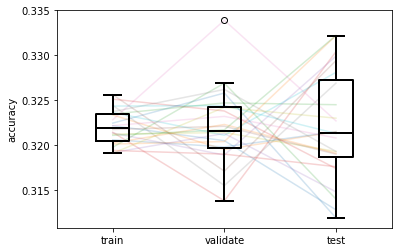

In [72]:
a = plot_hist(path)

file ../results/dnn/2019-04-24-22-01/dnn_model_1_all_runs_p3_ecoli_100000_10000_6_0.pyob
Number of runs 24
MannwhitneyuResult(statistic=278.0, pvalue=0.42234942432820904)


<function matplotlib.pyplot.show>

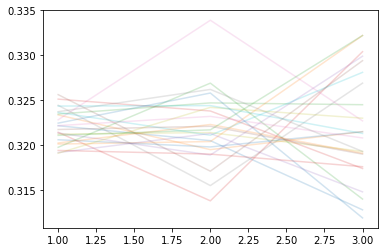

In [58]:
%matplotlib inline
statistics_file = glob.glob(os.path.join(path, "*all_runs*"))[0]
print("file {}".format(statistics_file))
with open(statistics_file, "rb") as file:
    (test_accs, train_accs) = pickle.load(file) 

val_accs = validation_accs(path)
print("Number of runs {}".format(len(test_accs)))

print(scipy.stats.mannwhitneyu(val_accs, train_accs)) 

for i in range(len(test_accs)):
    plt.plot([1, 2, 3], [train_accs[i], val_accs[i], test_accs[i]], alpha = 0.2)
plt.show